In [62]:
import shutil
shutil.rmtree("c:/users/janneke/anaconda3/lib/site-packages/~atplotlib",  ignore_errors=True)
shutil.rmtree("c:/users/janneke/anaconda3/lib/site-packages/~atplotlib-3.2.0.dist-info",  ignore_errors=True)
shutil.rmtree("c:/users/janneke/anaconda3/lib/site-packages/~ensorflow",  ignore_errors=True)

In [1]:
!pip install pillow==8.1.0
!pip install -U matplotlib
!pip install numpy==1.19.3
!pip install opencv-python==4.5.1.48
!pip install tqdm==4.56.0
!pip install requests==2.25.1

!pip install mediapipe==0.8.3


In [4]:
!pip install tensorflow

  Using cached tensorflow-2.7.0-cp39-cp39-win_amd64.whl (430.8 MB)


In [25]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [26]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests

class PoseClassificationVisualizer(object):
  """Keeps track of claassifcations for every frame and renders them."""

  def __init__(self,
               class_name,
               plot_location_x=0.05,
               plot_location_y=0.05,
               plot_max_width=0.4,
               plot_max_height=0.4,
               plot_figsize=(9, 4),
               plot_x_max=None,
               plot_y_max=None,
               counter_location_x=0.85,
               counter_location_y=0.05,
               counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
               counter_font_color='red',
               counter_font_size=0.15):
    self._class_name = class_name
    self._plot_location_x = plot_location_x
    self._plot_location_y = plot_location_y
    self._plot_max_width = plot_max_width
    self._plot_max_height = plot_max_height
    self._plot_figsize = plot_figsize
    self._plot_x_max = plot_x_max
    self._plot_y_max = plot_y_max
    self._counter_location_x = counter_location_x
    self._counter_location_y = counter_location_y
    self._counter_font_path = counter_font_path
    self._counter_font_color = counter_font_color
    self._counter_font_size = counter_font_size

    self._counter_font = None

    self._pose_classification_history = []
    self._pose_classification_filtered_history = []

  def __call__(self,
               frame,
               pose_classification,
               pose_classification_filtered,
               repetitions_count):
    """Renders pose classifcation and counter until given frame."""
    # Extend classification history.
    self._pose_classification_history.append(pose_classification)
    self._pose_classification_filtered_history.append(pose_classification_filtered)

    # Output frame with classification plot and counter.
    output_img = Image.fromarray(frame)

    output_width = output_img.size[0]
    output_height = output_img.size[1]

    # Draw the plot.
    img = self._plot_classification_history(output_width, output_height)
    img.thumbnail((int(output_width * self._plot_max_width),
                   int(output_height * self._plot_max_height)),
                  Image.ANTIALIAS)
    output_img.paste(img,
                     (int(output_width * self._plot_location_x),
                      int(output_height * self._plot_location_y)))

    # Draw the count.
    output_img_draw = ImageDraw.Draw(output_img)
    if self._counter_font is None:
      font_size = int(output_height * self._counter_font_size)
      font_request = requests.get(self._counter_font_path, allow_redirects=True)
      self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * self._counter_location_y),
                         str(repetitions_count),
                         font=self._counter_font,
                         fill=self._counter_font_color)

    return output_img

  def _plot_classification_history(self, output_width, output_height):
    fig = plt.figure(figsize=self._plot_figsize)

    for classification_history in [self._pose_classification_history,
                                   self._pose_classification_filtered_history]:
      y = []
      for classification in classification_history:
        if classification is None:
          y.append(None)
        elif self._class_name in classification:
          y.append(classification[self._class_name])
        else:
          y.append(0)
      plt.plot(y, linewidth=7)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Frame')
    plt.ylabel('Confidence')
    plt.title('Classification history for `{}`'.format(self._class_name))
    plt.legend(loc='upper right')

    if self._plot_y_max is not None:
      plt.ylim(top=self._plot_y_max)
    if self._plot_x_max is not None:
      plt.xlim(right=self._plot_x_max)

    # Convert plot to image.
    buf = io.BytesIO()
    dpi = min(
        output_width * self._plot_max_width / float(self._plot_figsize[0]),
        output_height * self._plot_max_height / float(self._plot_figsize[1]))
    fig.savefig(buf, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img

In [27]:
csvs_out_train_path = 'yoga_poses_csvs_out.csv'
csvs_out_test_path = 'yoga_test_poses_csvs_out.csv'

In [28]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates (33 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path, header=None)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process = df_to_process.iloc[: , 1:]

  # # Extract the list of class names
  # classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop(df_to_process.columns[0])

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float32')
  y = keras.utils.to_categorical(y)

  return X, y, dataframe

In [29]:
# Load the train data
X, y, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15, shuffle = True)
print(X_train)
print(X_val.shape)
print(y_train)
print(y_val.shape)

            2           3           4           5           6           7    \
846  784.011658  632.374268  102.502502  810.567871  644.229797  120.089294   
890  168.190186  442.278625   -7.729155  160.509720  437.784973  -18.650139   
173  713.313232  456.756683 -204.839203  725.242188  443.495972 -215.858368   
401  640.976685  152.242584  -83.139313  652.393921  140.046524  -62.047173   
155  557.667603  410.588745 -171.708725  549.925659  402.774628 -148.873795   
..          ...         ...         ...         ...         ...         ...   
764  248.731567  190.517059  -34.931278  244.433960  199.660248  -60.714375   
893  249.465530  257.306122  -49.135761  240.156921  255.359634  -49.991688   
422  475.299408  251.759766 -348.186005  497.161469  229.656448 -314.263000   
359  673.141724   95.204697 -203.985901  686.285889   83.190514 -188.604263   
301  359.105804  279.345764 -125.746193  364.901520  274.391785 -116.411789   

            8           9           10          11 

In [43]:
from sklearn.utils import shuffle

# Load the test data
X_test, y_test, df_test = load_pose_landmarks(csvs_out_test_path)
# X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()
X_test, y_test = shuffle(X_test, y_test)

print(X_test)
print(y_test)

            2           3           4           5           6           7    \
15   462.128113  235.177216 -460.839050  475.976868  213.961060 -424.324463   
136  157.763443   98.427750 -147.202576  163.102341   93.730583 -149.168198   
303  189.575470  326.532654  -49.875916  183.097672  318.319641  -67.000565   
421  220.308990  250.189270  -36.410355  213.079391  254.286850  -50.750114   
6    650.361206  346.888580 -383.544739  667.506348  311.133514 -313.020935   
..          ...         ...         ...         ...         ...         ...   
374  311.610870  248.034744  -67.428886  303.978729  252.486969  -94.012093   
218  564.138916  355.724670 -576.481934  571.282715  340.003845 -538.046631   
142  347.943268  353.749359 -274.049255  357.783386  342.960876 -269.756989   
83   424.308044  465.764099 -332.365601  418.300385  451.930664 -307.681305   
64   501.550110   73.485016 -121.206573  510.516785   62.977882  -95.825241   

            8           9           10          11 

In [31]:
# # Define the model
inputs = tf.keras.Input(shape=(99))
# # embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(256, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.2)(layer)
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.2)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.2)(layer)
layer = keras.layers.Dense(32, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.2)(layer)
layer = keras.layers.Dense(16, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.2)(layer)
outputs = keras.layers.Dense(5, activation="softmax")(layer)


# # layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
# layer = keras.layers.Dense(128)(inputs)
# layer = keras.layers.Dropout(0.2)(layer)
# layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.2)(layer)
# outputs = keras.layers.Dense(5, activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()
print(model.layers[0].weights)
print(model.layers[1].weights)
print(model.layers[2].weights)
print(model.layers[3].weights)
print(model.layers[4].weights)
print(model.layers[5].weights)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 99)]              0         
                                                                 
 dense_8 (Dense)             (None, 256)               25600     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

In [32]:
import numpy as np
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)
    landmarks = np.float32(landmarks)

    return landmarks

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)
    # print(landmarks.shape)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    print("center: ")
    print(pose_center)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier).astype("float32")
    print("pose size: ")
    print(pose_size)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it easier to debug.
    # landmarks *= 100

    return landmarks

  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.
    
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """

    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]
    

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5
    print("hips center: ")
    print(hips)

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5
    print("shoulder center: ")
    print(shoulders)
    
    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips).astype("float32")
    
    print("torso_size:" )
    print(torso_size)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))
    print("max distance: ")
    print(max_dist)

    return max(torso_size * torso_size_multiplier, max_dist)


  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

In [33]:
import pandas as pd

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)


pose_embedder = FullBodyPoseEmbedder()
# # Calling DataFrame constructor on list
# df = pd.DataFrame(X_train)
# # print(df.shape)
# df.astype('float64')
# print(df.shape)
booly = 0
landmarks = X_train.to_numpy().astype("float32")
validation = X_val.to_numpy().astype("float32")
val_landmarks = []
norm_landmarks = []
for x in landmarks:
  if(booly==0):
    print(x)
  y = np.reshape(x,[-1,3])
  # print(y.shape)
  embedding = pose_embedder(y)
  if(booly==0):
    print(embedding)
    booly=1
  # print(embedding)
  norm_landmarks.append(embedding)

for z in validation:
  p = np.reshape(z,[-1,3])
  # print(p.shape)
  embedding = pose_embedder(p)
  # print(embedding)
  val_landmarks.append(embedding)

# embedding = landmarks_to_embedding(X_train)
# embedding_val = landmarks_to_embedding(X_val)
norm_landmarks = np.array(norm_landmarks)
norm_landmarks = np.reshape(norm_landmarks, [-1,99])
val_landmarks = np.array(val_landmarks)
val_landmarks = np.reshape(val_landmarks, [-1,99])
print(norm_landmarks)
print(y_train)
# Start training
# estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
# history = model.fit(norm_landmarks, y_train, epochs = 200, batch_size=5, verbose=0, validation_data = (val_landmarks, y_val))
history = model.fit(norm_landmarks, y_train,
                    epochs=200,
                    batch_size=16,
                    shuffle = True,
                    validation_data=(val_landmarks, y_val),
                    callbacks=[checkpoint, earlystopping],
                    verbose = 2)

print(model.layers[1].weights)

[ 784.01166   632.37427   102.5025    810.5679    644.2298    120.089294
  811.9797    641.1074    120.50608   813.29755   638.72845   120.196465
  814.5888    643.4258     55.74662   820.41437   640.6373     55.772583
  825.774     637.61835    55.30935   826.1358    616.1173    202.04074
  848.24066   610.3945    -89.69602   775.5366    605.0167    148.30313
  782.3356    605.3052     63.686268  811.7252    497.97256   339.13824
  854.7804    516.40576  -154.53676   969.54333   593.43787   566.88336
 1036.728     608.78143  -427.1864   1116.0415    614.7008    285.27496
 1242.4008    660.0855   -331.88235  1166.3872    586.5849    317.82776
 1317.3237    659.4597   -372.7093   1181.6315    598.07745   246.99127
 1317.4948    645.2495   -285.95285  1159.0586    618.056     259.00983
 1283.5527    651.30975  -295.17807   380.12155   266.13864   208.16312
  392.70605   274.56842  -208.04527   260.076     559.00525   387.9775
  294.5129    586.2878    -20.135397  136.17575   784.7548    

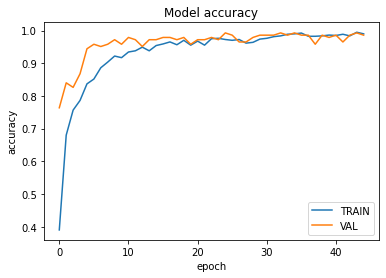

In [34]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [44]:
test_landmarks = X_test.to_numpy()
norm_test_landmarks = []
for x in test_landmarks:
  y = np.reshape(x,[-1,3])
#   print(y)
  embedding = pose_embedder(y)
  print(embedding)
  norm_test_landmarks.append(embedding)

norm_test_landmarks = np.array(norm_test_landmarks)
norm_test_landmarks = np.reshape(norm_test_landmarks, [-1,99])
# print(norm_test_landmarks)
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(norm_test_landmarks, y_test)

center: 
[4.8613956e+02 5.7997748e+02 2.1652675e-01]
hips center: 
[0. 0.]
shoulder center: 
[ -11.634552 -232.74782 ]
torso_size:
233.03844
max distance: 
441.92764
pose size: 
582.59607
[[-4.12145667e-02 -5.91834188e-01 -7.91381180e-01]
 [-1.74438003e-02 -6.28250778e-01 -7.28705525e-01]
 [-1.32961362e-03 -6.29607856e-01 -7.28795171e-01]
 [ 1.49254277e-02 -6.31268799e-01 -7.28950024e-01]
 [-6.21305630e-02 -6.23060405e-01 -7.23746240e-01]
 [-7.77131766e-02 -6.21306658e-01 -7.23869622e-01]
 [-9.32873562e-02 -6.19361103e-01 -7.23980963e-01]
 [ 4.40643057e-02 -6.05248928e-01 -3.87482077e-01]
 [-1.06904387e-01 -5.91064215e-01 -3.53343070e-01]
 [-6.56231865e-03 -5.51323712e-01 -6.68327153e-01]
 [-6.47686794e-02 -5.45588076e-01 -6.58670664e-01]
 [ 1.47613719e-01 -4.07769978e-01 -1.85192078e-01]
 [-1.87554091e-01 -3.91232401e-01 -1.79674894e-01]
 [ 2.81118810e-01 -1.51934087e-01 -3.71869326e-01]
 [-2.92059422e-01 -9.48883072e-02 -3.44507366e-01]
 [ 6.25891685e-02 -1.51094720e-01 -6.72845840e-

[9.9998641e-01 7.2141484e-06 9.5475642e-08 5.9987451e-06 2.3600337e-07]
[7.6185461e-06 9.9999094e-01 1.1062688e-07 9.4076029e-08 1.1696999e-06]
[1.05209985e-07 2.64502531e-10 3.98128774e-09 9.99983668e-01
 1.62207270e-05]
[9.0827632e-12 2.9900566e-09 2.4258862e-10 3.7780651e-06 9.9999619e-01]
[9.9998760e-01 5.8229903e-06 8.7880601e-08 6.1604123e-06 2.4368248e-07]
[8.3677851e-06 9.9999022e-01 1.2090982e-07 9.4056951e-08 1.1707759e-06]
[9.9998558e-01 8.1125872e-06 9.9911645e-08 5.9119757e-06 2.3189912e-07]
[1.0616647e-07 2.6888411e-10 3.9390331e-09 9.9998343e-01 1.6424532e-05]
[7.5165837e-12 3.3552112e-09 2.8525196e-10 2.3456671e-06 9.9999762e-01]
[3.4144730e-05 9.9996400e-01 2.4315835e-07 2.4298865e-07 1.4320747e-06]
[1.1148252e-07 2.9381775e-10 3.7185586e-09 9.9998236e-01 1.7569788e-05]
[4.1953948e-07 1.0890395e-06 9.9999678e-01 3.2295436e-08 1.6266708e-06]
[1.0632981e-07 2.6963495e-10 3.9319095e-09 9.9998343e-01 1.6459389e-05]
[1.1784957e-11 2.3154527e-09 1.9719842e-10 8.9543473e-06 9

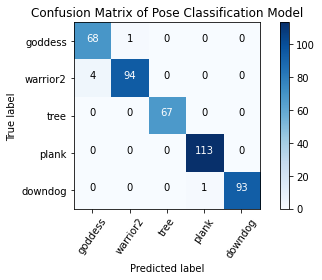

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(norm_test_landmarks)
rounded_pred = np.argmax(y_pred, axis=-1)
for i in y_pred:
  print(i)

class_names = ["goddess", "warrior2", "tree", "plank", "downdog"]

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [37]:
# !mkdir -p saved_model
model.save('saved_model/my_model')
print(model.layers[0].weights)
print(model.layers[1].weights)
print(model.layers[2].weights)
print(model.layers[3].weights)
print(model.layers[4].weights)
print(model.layers[5].weights)


converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# # converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('finalModel3.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


[]
[<tf.Variable 'dense_8/kernel:0' shape=(99, 256) dtype=float32, numpy=
array([[-0.06355926,  0.09413289, -0.08489067, ..., -0.03147211,
        -0.15903544,  0.05578635],
       [ 0.07374914,  0.21342711,  0.00569489, ...,  0.11354739,
        -0.06250845, -0.09808359],
       [-0.01826529,  0.02983764,  0.0469997 , ..., -0.05731998,
        -0.13972622, -0.01701173],
       ...,
       [ 0.15402025, -0.07075862, -0.11998254, ..., -0.1059367 ,
         0.1822729 ,  0.01242929],
       [ 0.06446999,  0.06461404,  0.0053387 , ...,  0.06150745,
        -0.00185167, -0.15089828],
       [-0.02983374,  0.12221364,  0.09060864, ...,  0.11594867,
         0.04877736, -0.05512071]], dtype=float32)>, <tf.Variable 'dense_8/bias:0' shape=(256,) dtype=float32, numpy=
array([-0.03576009, -0.01231905, -0.04123889, -0.01558704, -0.05314398,
       -0.00928567, -0.01907261, -0.03009582, -0.03041846, -0.04671131,
       -0.02869862, -0.02311667,  0.00364517, -0.03116255,  0.0148854 ,
       -0.01593